**IMPORT DATASET**

In [1]:
!wget 'http://genome.crg.es/datasets/ggalhsapgenes2005/hg16.311.putative.aa.fa'

--2019-03-27 16:24:20--  http://genome.crg.es/datasets/ggalhsapgenes2005/hg16.311.putative.aa.fa
Resolving genome.crg.es (genome.crg.es)... 84.88.66.242
Connecting to genome.crg.es (genome.crg.es)|84.88.66.242|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52878 (52K) [text/plain]
Saving to: ‘hg16.311.putative.aa.fa’

hg16.311.putative.a 100%[===================>]  51.64K  90.9KB/s    in 0.6s    

2019-03-27 16:24:26 (90.9 KB/s) - ‘hg16.311.putative.aa.fa’ saved [52878/52878]



In [2]:
!pip install biopython
!pip install dna_features_viewer
!ls

    100% |████████████████████████████████| 2.2MB 12.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/bd/66/50/0e0ea0846be6d2b204676646640d8309299f7c01ae6ba5fd97
Successfully built dna-features-viewer
hg16.311.putative.aa.fa  sample_data


### **Parsing FASTA file into a dataframe**

In [3]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from numpy import *
import pandas as pd
# dataset = df.Dataframe[]
with open('hg16.311.putative.aa.fa') as file: 
    title = []
    length = []
    sequences = []
    for name, dna_sequence in SimpleFastaParser(file):
        title.append(name.split(None, 1)[0])
        sequences.append(dna_sequence)
        length.append(len(dna_sequence))

df = pd.DataFrame({'ID':title, 'sequence':sequences,'length':length})
df.head(5)

,ID,length,sequence
0,chr10_1000,120,MAQTRYTQNRWRNEACREKALSTCGCSANVSQPTITTLLTPLTSET...
1,chr10_125,104,MELRALEADLNFLSVILFATFIFSLPLRLLIVIFQRYWAPASTLPP...
2,chr10_1324,109,MEEFIAQKIPFCYLIQKVQSPQLRKIYFPHFNTLQNSPHNSSECVK...
3,chr10_150,66,MRCPKSAVTMRNEELLLSMIKSCFESTIASRDLRLEFNKLLRRLKS...
4,chr10_1503,104,MAGDLEDWRQQARSALPFETPNCYLLSEIKRQITFLLLIISFLTRF...


In [4]:
!pip install plotly

**Upload Matrix**

In [5]:
from google.colab import files
files.upload()

{}

In [0]:
import pandas as pd
from numpy import *
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
similarity_df=pd.read_csv('matrix_np1.csv', sep=',',header=None)
similarity_np = loadtxt('matrix_np1.csv', delimiter=',')
z = similarity_np
data = arange(shape(z)[0])
data = data.reshape(len(data), 1)

## DIVISIVE CLUSTERING

In [0]:
def distEclud(vecA, vecB):
  return sqrt(sum(power(vecA - vecB, 2)))

In [0]:
def randCent(dataSet, k):
  n = shape(dataSet)[1]
  centroids = mat(zeros((k,n)))
  for j in range(n):
    centroids[:,j] = [dataSet[x,0] for x in random.choice(len(dataSet),size=(k,1),replace=False).tolist()] 
  return centroids

In [0]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
  m = shape(dataSet)[0]
  clusterAssment = mat(zeros((m,2)))
  centroids = createCent(dataSet, k).astype(int)
  clusterChanged = True
  while clusterChanged:
    clusterChanged = False
    for i in range(m):
      minDist = inf; minIndex = -1
      for j in range(k):
        distJI = z[centroids[j,0]][dataSet[i,0]]
       # distJI = z1[centroids[j,0]][dataSet[i]]
        if distJI < minDist:
          minDist = distJI; minIndex = j
      if clusterAssment[i,0] != minIndex: clusterChanged = True
      clusterAssment[i,:] = minIndex,minDist
       
    for cent in range(k):
      ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]
      ptsInClust = ptsInClust.reshape(len(ptsInClust))
      minDist = inf; minIndex = -1
      for pt in ptsInClust:
        distPt = sum([ z[pt][x] for x in ptsInClust])
        if distPt < minDist:
          minDist = distPt
          minIndex = pt
      centroids[cent,0] = minIndex
            
  return centroids, clusterAssment

In [0]:
ce,ass = kMeans(data,2)
ce

matrix([[304],
        [149]])

In [0]:
def divisive(dataSet, k, count, distMeas=distEclud):
  m = shape(dataSet)[0]
  clusterAssment = mat(zeros((m,2)))
  minDist = inf; minIndex = -1
  for pt in range(len(dataSet)):
    distPt = sum([ z[pt][x] for x in range(len(dataSet)) ])
    if distPt < minDist:
      minDist = distPt
      minIndex = pt
  centroid0 = minIndex
  centList =[centroid0]
  for j in range(m):
    clusterAssment[j,1] = z[centroid0][j]
    
  while (len(centList) < k):
    lowestSSE = inf
    for i in range(len(centList)):
      ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]
      #print(shape(ptsInCurrCluster))
      if(len(ptsInCurrCluster) == 1):
        continue
      centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2 , distMeas)
      sseSplit = sum(splitClustAss[:,1])
      sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
      #print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
      if (sseSplit + sseNotSplit) < lowestSSE:
        bestCentToSplit = i
        bestNewCents = centroidMat
        bestClustAss = splitClustAss.copy()
        lowestSSE = sseSplit + sseNotSplit
    
    temp1 = nonzero(bestClustAss[:,0].A == 1)[0]
    temp2 = nonzero(bestClustAss[:,0].A == 0)[0]
  
    X[count] = array([bestCentToSplit, len(centList), lowestSSE, len(temp1)+len(temp2)])
    count = count + 1
    
    bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList)
    bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
    #print ('the bestCentToSplit is: ',bestCentToSplit)
    #print ('the len of bestClustAss is: ', len(bestClustAss), '\n')
    
    centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]
    centList.append(bestNewCents[1,:].tolist()[0])
    clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss
    
  return mat(centList), clusterAssment

In [0]:
def findOrder(val, iteration, n):
  while(val in order):
    val = n + order[val]
  order[val] = iteration
  return val

In [0]:
X = zeros((len(data)-1,4))
count = 0
centList, clusterAssment = divisive(data, 310, count)
#centList

In [0]:
pointAssment = {}
order = {}
n = len(X)+1
for i in range(len(clusterAssment)):
  pointAssment[int(clusterAssment[i,0])] = i
Q = X[::-1]

#Q is the linkage matrix

for i in range(len(Q)):
  Q[i,0] = pointAssment[Q[i,0]]
  Q[i,1] = pointAssment[Q[i,1]]
for i in range(len(Q)):
  Q[i,0] = findOrder(Q[i,0],i,n)
  Q[i,1] = findOrder(Q[i,1],i,n)
Q

array([[2.4200e+02, 2.3100e+02, 0.0000e+00, 2.0000e+00],
       [3.9000e+01, 3.0700e+02, 4.2000e+01, 2.0000e+00],
       [3.1000e+02, 2.3800e+02, 8.7000e+01, 3.0000e+00],
       ...,
       [6.0700e+02, 6.1200e+02, 4.7745e+04, 1.9900e+02],
       [6.1100e+02, 6.1500e+02, 5.0292e+04, 1.1100e+02],
       [6.1700e+02, 6.1600e+02, 5.2898e+04, 3.1000e+02]])

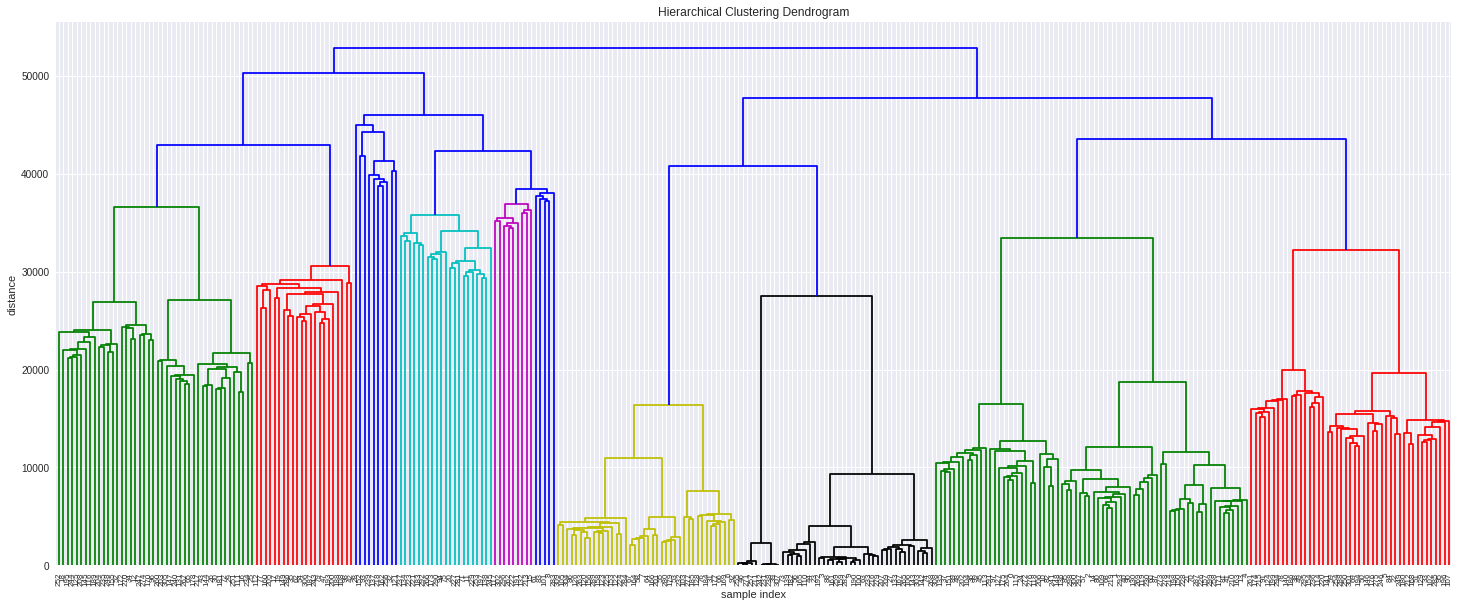

In [0]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Q,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()